# 如何绘制散点图和热力图
数据：  
1.出租车原始GPS数据(在data-sample文件夹下，原始数据集的抽样500辆车的数据)

在实际的项目或者论文中，我们经常要绘制一下数据的分布情况，这就需要绘制散点图（以颜色代表数据量）或者热力图。可是很可惜我翻遍了matplotlib和seaborn的包都没有找到地图热力图的绘制方法，他们的热力图就是格子填颜色，这样子根本就不是我们想要的效果嘛！

### 1.数据集计处理
绘制数据分布的时候，首先第一步还是得将数据集计，得到每一个小范围内的数据量是多少。我这里采用的是经纬度小数点保留三位小数

In [1]:
import pandas as pd
#读取数据
data = pd.read_csv(r'data-sample\TaxiData-Sample',header = None)
#给数据命名列
data.columns = ['VehicleNum', 'Stime', 'Lng', 'Lat', 'OpenStatus', 'Speed']

#筛选范围内数据
bounds = [113.7, 22.42, 114.3, 22.8]
data = data[(data['Lng']>bounds[0])&(data['Lng']<bounds[2])&(data['Lat']>bounds[1])&(data['Lat']<bounds[3])]

#经纬度小数点保留三位小数
data2 = data[['Lng','Lat']].round(3).copy()

#集计每个小范围内数据量
data2['count'] = 1
data2 = data2.groupby(['Lng','Lat'])['count'].count().reset_index()

#排序数据，让数据量小的放上面先画，数据大的放下面最后画
data2.sort_values(by = 'count')

data2.head(5)

,Lng,Lat,count
0,113.701,22.779,1
1,113.703,22.779,1
2,113.715,22.781,1
3,113.717,22.780,1
4,113.723,22.769,1


### 2.散点图绘制

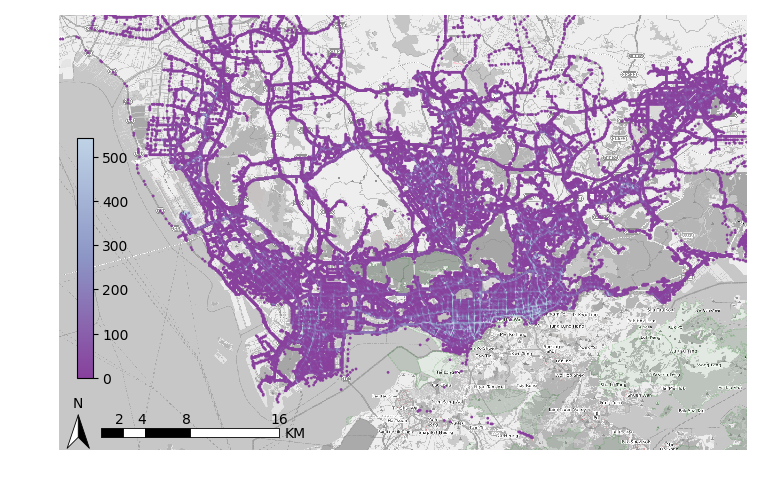

In [3]:
bounds = [113.7, 22.42, 114.3, 22.8]

import matplotlib as mpl
import matplotlib.pyplot as plt
import plot_map
import seaborn as sns
fig     = plt.figure(1,(8,8),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))

#背景
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)


#colorbar
pallete_name = "BuPu"
colors = sns.color_palette(pallete_name, 3)
colors.reverse()
cmap = mpl.colors.LinearSegmentedColormap.from_list(pallete_name, colors)
vmax = data2['count'].quantile(0.99)
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)


#plot scatters
plt.scatter(data2['Lng'],data2['Lat'],s = 1,alpha = 1,c = data2['count'],cmap = cmap,norm=norm )
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

# 加比例尺和指北针
plot_map.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,accuracy = 2000,rect = [0.06,0.03])

#假的 colorbar
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.13, 0.33, 0.02, 0.3])
plt.colorbar(cax=cax)

plt.show()

### 3.热力图绘制(contourf)
热力图绘制这里我们采用plt的contourf函数绘制，而contourf所传入的参数是一个矩阵形式

plt.contourf(x,y,z, levels=levels, cmap=cmap,origin = 'lower')

这里传入的参数是

x--一维横坐标
y--一维纵坐标
z--二维矩阵值
levels--分层的颜色



In [4]:
#因此我们用pd.pivot透视表来生成x,y,z
#在这里我对z取一个log,这样可视化出来效果更优美
#用 pd.pivot 生成 x, y, z

import numpy as np

d = data2.pivot(columns = 'Lng',index = 'Lat',values = 'count').fillna(0)
z = np.log(d.values)
x = d.columns
y = d.index

levels = np.linspace(0, z.max(), 25)



C:\Program Files\Python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


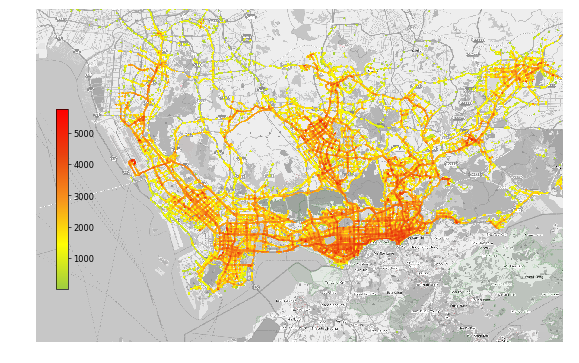

In [5]:
bounds = [113.7, 22.42, 114.3, 22.8]  #用于绘制底图

#导入绘图包
import matplotlib as mpl
import matplotlib.pyplot as plt
import plot_map
import seaborn as sns
import numpy as np

#   -- plot --
fig     = plt.figure(1,(10,10),dpi = 60)  
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))#调整整体空白

#绘制底图
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

#colorbar的数据
import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', ['#9DCC42','#FFFE03','#F7941D','#E9420E','#FF0000'], 256)

#绘制热力图
plt.contourf(x,y,z, levels=levels, cmap=cmap,origin = 'lower')


plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

#绘制假的colorbar
plt.imshow([np.exp(levels)], cmap=cmap)
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)


plt.show()

但是，这种绘制热力图的方式对数据要求较高，需要数据分布比较密集，否则画不出这么好的效果

### 4.热力图绘制(seaborn-kdeplot)
seaborn-kdeplot也是绘制热力图的一种方式，但是这种方式缺点有以下几个：  

1.由于kdeplot绘制不支持为数据点加权重，无法用先集计后绘制的方法，只能输入整个数据集绘制，如果数据量大，绘制速度极慢  
2.绘制的依据为进行核密度估计后的值，这一值是抽象的只能显示相对关系，无法对应实际的物理意义  
3.核密度会导致绘图精度丢失，你只能看到一坨东西在那  

In [6]:
#筛选范围内的数据点
data = data[(data['Lng']>bounds[0])&(data['Lng']<bounds[2])&(data['Lat']>bounds[1])&(data['Lat']<bounds[3])]
#抽样
datasample = data.sample(10000)

C:\Users\aaa\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\aaa\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.03 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\aaa\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


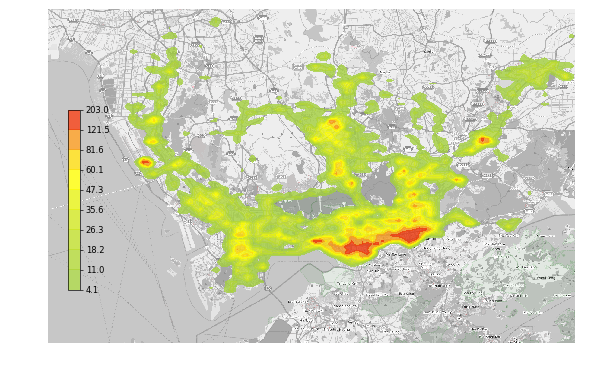

In [9]:
bounds = [113.7, 22.42, 114.3, 22.8]

#导入绘图包
import matplotlib as mpl
import matplotlib.pyplot as plt
import plot_map
import seaborn as sns
import numpy as np

#   -- plot --
fig     = plt.figure(1,(10,10),dpi = 60)  
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))#调整整体空白

#绘制底图
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

#colorbar的数据
import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', ['#9DCC42','#FFFE03','#F7941D','#E9420E','#FF0000'], 256)


plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

#定义colorbar位置
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
#绘制热力图
sns.kdeplot(datasample['Lng'],datasample['Lat'],
            alpha = 0.8,#透明度
            gridsize = 100, #绘图精细度，越高越慢
            bw = 0.03,    #高斯核大小（经纬度），越小越精细
            shade=True,
            shade_lowest=False,
            cbar=True,
            cmap = cmap,
            ax = ax, #指定绘图位置
            cbar_ax=cax#指定colorbar位置
           )

plt.show()

### 5.热力图绘制（scipy）
上面提到，seaborn-kdeplot的缺点数据点加权重，无法用先集计后绘制的方法，只能输入整个数据集绘制，如果数据量大，绘制速度极慢  
自行编写heatmapplot函数绘制热力图

In [12]:
def heatmapplot(data,weight,gridsize = 100,bw = 'scott',cmap = plt.cm.gist_earth_r, ax=None,**kwargs):
    #数据整理
    from scipy import stats
    m1 = data[:,0]
    m2 = data[:,1]
    xmin = m1.min()
    xmax = m1.max()
    ymin = m2.min()
    ymax = m2.max()
    X, Y = np.mgrid[xmin:xmax:(xmax-xmin)/gridsize, ymin:ymax:(ymax-ymin)/gridsize]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([m1, m2])
    #用scipy计算带权重的高斯kde
    kernel = stats.gaussian_kde(values,bw_method = bw,weights = weight)
    Z = np.reshape(kernel(positions).T, X.shape)
    #绘制contourf
    cset = ax.contourf(Z.T,extent=[xmin, xmax, ymin, ymax],cmap = cmap,**kwargs)
    #设置最底层为透明
    cset.collections[0].set_alpha(0)
    
    return cset

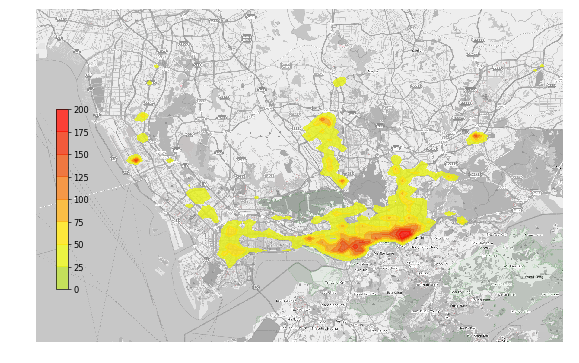

In [13]:
bounds = [113.7, 22.42, 114.3, 22.8]

#导入绘图包
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import plot_map
import seaborn as sns
import numpy as np

#   -- plot --
fig     = plt.figure(1,(10,10),dpi = 60)    
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))#调整整体空白

#绘制底图
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

#colorbar的数据
import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', ['#9DCC42','#FFFE03','#F7941D','#E9420E','#FF0000'], 256)

#设定位置
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

#绘制热力图
cset = heatmapplot(data2.values,  #输入经纬度数据
            data2['count'],       #输入每个点的权重
            alpha = 0.8,          #透明度
            gridsize = 80,        #绘图精细度，越高越慢
            bw = 0.03,            #高斯核大小（经纬度），越小越精细
            cmap = cmap,
            ax = ax
           )

#定义colorbar位置
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cset,cax=cax)


plt.show()